In [196]:
from PIL import Image
import numpy as np


In [197]:
import time
start = time.time()


FLAGS


In [198]:
filename="lena_watermarked_edited2"
ext="png"

In [199]:
CHECKONSTEP = True


blocks getting function


In [200]:
def getblocks(image: np.ndarray, blockshape: tuple, moveAxis: bool = True, info: bool = False, addChannel: bool = True) -> np.ndarray:
    '''
    takes the array of image in grey= 2D and in RGB = 3D
    takes the numpy array and converts it the the blocks in the fastest way
    '''
    if(info):
        print("Image Shape:", image.shape)
        print("Block Shape:", blockshape)

    oldshape = list(image.shape)
    if addChannel and len(image.shape) == 2:
        mode = "grey"
        image = image.reshape((*image.shape, 1))
    else:
        mode = "color"

    if addChannel:
        img_height, img_width, channels = image.shape
    else:
        img_height, img_width = image.shape

    tile_height, tile_width = blockshape

    if addChannel:
        shp = img_height//tile_height, tile_height, img_width//tile_width, tile_width, channels
    else:
        shp = img_height//tile_height, tile_height, img_width//tile_width, tile_width

    def printinfo():
        print("Old Shape:", oldshape)
        print("Image Shape:", image.shape)
        print("Block Shape:", blockshape)
        print("New Shape Initial:", shp)
        print("img_height % tile_height != 0 :", img_height % tile_height != 0)
        print("img_width % tile_width != 0 :", img_width % tile_width != 0)

    if img_height % tile_height != 0 or img_width % tile_width != 0:
        print("warning: Block size is not fit for the image!")
        printinfo()

    if(info):
        printinfo()

    tiled_array = image.reshape(shp)
    tiled_array = tiled_array.swapaxes(1, 2)

    if moveAxis:
        if(addChannel):
            tiled_array = tiled_array.reshape(-1,
                                              *(tile_height, tile_width, channels))
            tiled_array = np.moveaxis(tiled_array, source=len(
                tiled_array.shape)-1, destination=1)
        else:
            tiled_array = tiled_array.reshape(-1, *(tile_height, tile_width))

    return tiled_array


In [201]:
def combineBlocks(tiled_array: np.ndarray, imageshape: tuple, blockshape: tuple, movedAxis: bool = True, channel: bool = True) -> np.ndarray:

    if channel:
        if len(imageshape) == 2:
            mode = "grey"
            imageshape = *imageshape, 1
        else:
            mode = "color"

    if channel:
        img_height, img_width, channels = imageshape
    else:
        img_height, img_width = imageshape

    tile_height, tile_width = blockshape

    if movedAxis:
        image = tiled_array.copy()
        if(channel):
            image=np.moveaxis(image, source=1, destination=-1)
            image = image.reshape(img_height//tile_height, tile_height,
                                  img_width//tile_width, tile_width, channels)
            swapaxisShape = list(image.shape)
            swapaxisShape[1], swapaxisShape[2] = swapaxisShape[2], swapaxisShape[1]
            image = image.reshape(swapaxisShape)
            image = image.swapaxes(1, 2)
        else:
            f = image.reshape(img_height//tile_height, tile_height,
                              img_width//tile_width, tile_width)
            swapaxisShape = list(f.shape)
            swapaxisShape[1], swapaxisShape[2] = swapaxisShape[2], swapaxisShape[1]
            tmp = f.reshape(swapaxisShape)
            image = tmp.swapaxes(1, 2)
    else:
        image = tiled_array
        # I haven't completed this else case. Btw we aren't using this case lol :)

    return image.reshape(imageshape)


In [202]:
def printnd(arr: np.ndarray):
    print("Shape:", arr.shape)
    print("Strides:", arr.strides)
    print(arr)


PSNR function


In [203]:
from math import log10, sqrt


In [204]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
        # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


importing image
e.g lena which is 512x512
importing as the grey image denoted by L flag


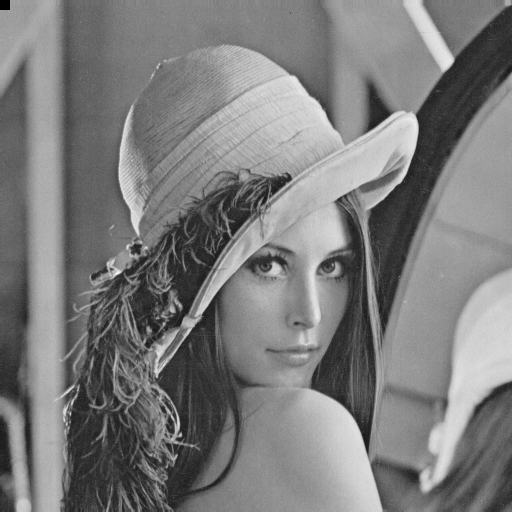

In [205]:
lena = Image.open(f"{filename}.{ext}").convert("L")
lena
# lena = Image.open("fyp_image.JPG").convert("L")
# lena


In [206]:
lena.mode


'L'

converting to np array


In [207]:
img = np.array(lena)
imgSize = img.shape
M, N = img.shape
img.shape, img.strides, img


((512, 512),
 (512, 1),
 array([[  0,   0,   0, ..., 169, 152, 129],
        [  0,   0,   0, ..., 170, 153, 128],
        [  0,   0,   0, ..., 171, 152, 128],
        ...,
        [ 41,  42,  48, ..., 106, 103,  96],
        [ 45,  46,  52, ..., 107, 105, 108],
        [ 45,  44,  55, ..., 107, 104, 111]], dtype=uint8))

In [208]:
if imgSize[0] % 64 != 0 or imgSize[1] % 64 != 0:
    raise Exception("Size not correct for embedding")


making 16 main blocks
size of single main block S= M/sqrt(16) X T=N/sqrt(16)
e.g for lena the 512x512 the partner blocks size would be 16 blocks each with size (512x512)/(4x4) = 128x128


In [209]:
PSNR(img, img)


100

In [210]:
mainblockSize = (int(imgSize[0]/4), int(imgSize[1]/4))
mainblocks = getblocks(img.copy(), mainblockSize, info=True)
mainblocks.shape, mainblocks.strides, mainblocks


Image Shape: (512, 512)
Block Shape: (128, 128)
Old Shape: [512, 512]
Image Shape: (512, 512, 1)
Block Shape: (128, 128)
New Shape Initial: (4, 128, 4, 128, 1)
img_height % tile_height != 0 : False
img_width % tile_width != 0 : False


((16, 1, 128, 128),
 (16384, 1, 128, 1),
 array([[[[  0,   0,   0, ..., 126, 135, 128],
          [  0,   0,   0, ..., 124, 134, 131],
          [  0,   0,   0, ..., 126, 132, 128],
          ...,
          [ 97,  99,  92, ..., 220, 208, 200],
          [ 89,  91,  93, ..., 219, 208, 190],
          [ 95,  92,  92, ..., 214, 207, 194]]],
 
 
        [[[133, 129, 135, ..., 130, 133, 136],
          [133, 131, 135, ..., 130, 134, 136],
          [135, 128, 134, ..., 130, 134, 137],
          ...,
          [189, 174, 144, ..., 186, 189, 195],
          [185, 178, 140, ..., 185, 187, 190],
          [189, 160, 163, ..., 179, 185, 180]]],
 
 
        [[[138, 142, 135, ..., 153, 152, 153],
          [138, 141, 132, ..., 153, 152, 153],
          [138, 141, 132, ..., 153, 153, 152],
          ...,
          [189, 185, 183, ..., 213, 219, 209],
          [197, 193, 185, ..., 217, 209, 203],
          [187, 198, 194, ..., 207, 195, 174]]],
 
 
        ...,
 
 
        [[[ 85, 105, 120, ...,  6

here the main blocks are like this index.
1st index is the block number.
2nd index is the channel (RGB) or 0 in Grey.
3rd and 4th are for indexing the block.


converting back and checking


In [211]:

mainblocks.shape, img.shape


((16, 1, 128, 128), (512, 512))

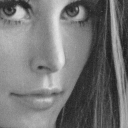

In [212]:

Image.fromarray(mainblocks[10][0], 'L')


In [213]:

combinedImg = combineBlocks(mainblocks, imgSize, mainblockSize)
combinedImg.shape, combinedImg
combinedImg = combinedImg.reshape(imgSize)
combinedImg.shape, combinedImg


((512, 512),
 array([[  0,   0,   0, ..., 169, 152, 129],
        [  0,   0,   0, ..., 170, 153, 128],
        [  0,   0,   0, ..., 171, 152, 128],
        ...,
        [ 41,  42,  48, ..., 106, 103,  96],
        [ 45,  46,  52, ..., 107, 105, 108],
        [ 45,  44,  55, ..., 107, 104, 111]], dtype=uint8))

In [214]:

(combinedImg == img).all()


True

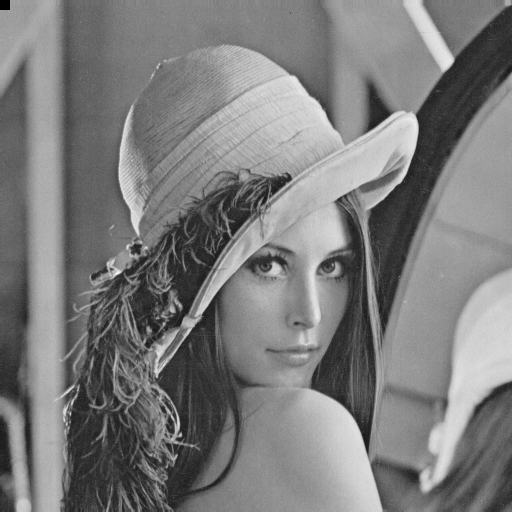

In [215]:

Image.fromarray(combinedImg, 'L')


In [216]:
PSNR(img, combinedImg)


100

lookup table


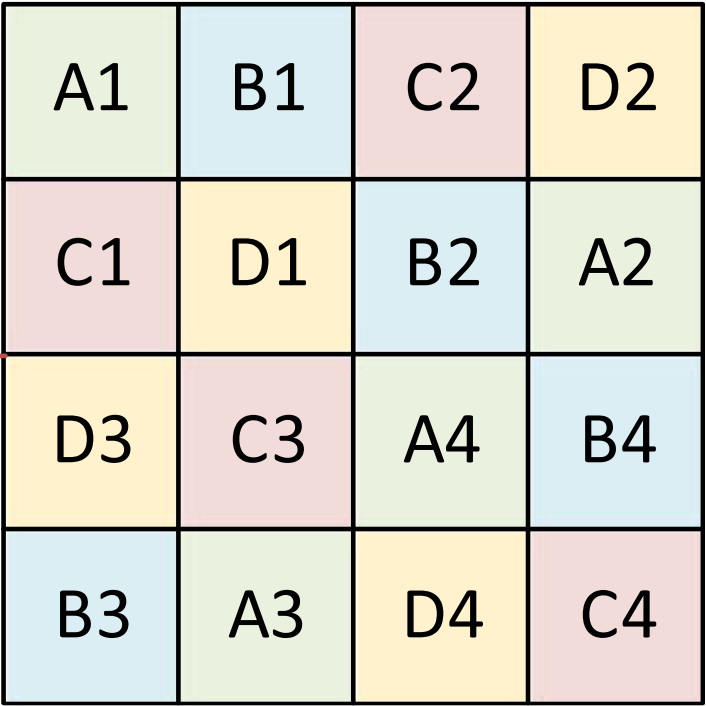

In [217]:
Image.open("lookup.png")


In [218]:
lookup = np.array([[0, 7, 13, 10],
                  [1, 6, 12, 11],
                  [4, 2, 9, 15],
                  [5, 3, 8, 14]], dtype=np.uint8)
lookup


array([[ 0,  7, 13, 10],
       [ 1,  6, 12, 11],
       [ 4,  2,  9, 15],
       [ 5,  3,  8, 14]], dtype=uint8)

here the every row represents the partner blocks
e.g
A1 will be lookup[0][0].
A2 will be lookup[0][2].
D2 will be lookup[3][2].


Step3
Ab har main block ko divide karo k 4x4 k block ban jain
numberOfBlocks=(SxT)/(4x4)
e.g 128x128/4x4 = 1024


In [219]:
avgblocksSize = (4, 4)
averages = np.zeros((16, int((mainblockSize[0]*mainblockSize[1]) /
                             (avgblocksSize[0]*avgblocksSize[1]))), dtype=np.uint8)
# 4 indicatior A,B,C,D, 4 blocks of A, then the 4x4 Blocks which have count = (SxT)/(4x4), e.g 1024


storing the averages of A, B, C, D


In [220]:
lookup


array([[ 0,  7, 13, 10],
       [ 1,  6, 12, 11],
       [ 4,  2,  9, 15],
       [ 5,  3,  8, 14]], dtype=uint8)

In [221]:
for partner in lookup:  # A,B,C,D
    for id in partner:  # A1,A2,A3.....D4 etc
        averages[id] = getblocks(mainblocks[id][0].copy(), avgblocksSize,
                                 info=False, addChannel=False).mean((1, 2))
averages.shape, averages


((16, 1024),
 array([[  0,   0,  80, ..., 114, 106, 199],
        [131, 128, 134, ..., 190, 185, 186],
        [136, 129, 132, ...,  46, 146, 207],
        ...,
        [101, 110, 112, ..., 136, 136, 134],
        [ 89, 101, 113, ..., 209, 211, 166],
        [126, 120, 131, ...,  69,  91, 103]], dtype=uint8))

array([[162, 162, 162, 161],
       [162, 162, 162, 161],
       [162, 162, 162, 161],
       [162, 162, 162, 161]], dtype=uint8)
this will give you the avg 161. But it sould be 162 as it's dominant. Minor improvemnt reuqired


now we have average of every mainblock according to 4x4. Which in total are 1024


time to convert them into the binary


In [222]:
averageBits = np.unpackbits(averages, axis=1)
averageBits.shape, averageBits


((16, 8192),
 array([[0, 0, 0, ..., 1, 1, 1],
        [1, 0, 0, ..., 0, 1, 0],
        [1, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 1, 1, ..., 1, 1, 0],
        [0, 1, 0, ..., 1, 1, 0],
        [0, 1, 1, ..., 1, 1, 1]], dtype=uint8))

merging partner blocks average to make the recovery bits


In [223]:
recoveryBits = np.zeros(
    (averageBits.shape[0], averageBits.shape[1]*3), dtype=np.uint8)
for partner in lookup:  # A,B,C,D
    for id in partner:  # A1,A2,A3.....D4 etc
        recoveryBits[id] = np.concatenate(
            [averageBits[i] for i in partner if i != id])

recoveryBits.shape, recoveryBits


((16, 24576),
 array([[1, 1, 0, ..., 1, 1, 0],
        [1, 0, 1, ..., 1, 1, 0],
        [0, 1, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 1, 1]], dtype=uint8))

password or key generation


In [224]:
import hashlib


In [225]:
# password or key
password = "this is my password"
key = [x for x in hashlib.sha256(password.encode()).digest()]
len(key)


32

permuttaion or shuffling


In [226]:
beforepermuted=recoveryBits.copy()

In [227]:
# for i in range(recoveryBits.shape[0]):
#     np.random.RandomState(seed=key).shuffle(recoveryBits[i])

recoveryBits.shape, recoveryBits


((16, 24576),
 array([[1, 1, 0, ..., 1, 1, 0],
        [1, 0, 1, ..., 1, 1, 0],
        [0, 1, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [0, 1, 0, ..., 1, 1, 1]], dtype=uint8))

Recovery bits creation completed
Now we need to make the space to put these recovery bits


### Making 16x16 for Step 8

Dividing the main blocks to 16x16 blocks
Total blocks = SxT/16x16 = 128x128/16x16 = 64 Blocks


In [228]:
mainblocks.shape


(16, 1, 128, 128)

In [229]:
blocks16x16Size = (16, 16)
# reshaping because we needed that shape
blocks16x16 = mainblocks.copy().reshape(
    *mainblocks.shape[:-2],
    int((mainblockSize[0]*mainblockSize[1]) /
        (blocks16x16Size[0]*blocks16x16Size[1])),
    blocks16x16Size[0], blocks16x16Size[1]).copy()

blocks16x16Size, blocks16x16.shape, blocks16x16.strides, blocks16x16


((16, 16),
 (16, 1, 64, 16, 16),
 (16384, 16384, 256, 16, 1),
 array([[[[[  0,   0,   0, ..., 163, 160, 155],
           [156, 159, 162, ..., 152, 153, 158],
           [155, 156, 153, ..., 175, 175, 168],
           ...,
           [109, 110, 104, ..., 110, 104, 111],
           [109, 110, 109, ..., 118, 123, 117],
           [113, 122, 123, ..., 124, 134, 131]],
 
          [[  0,   0,   0, ..., 162, 161, 152],
           [157, 156, 163, ..., 154, 154, 158],
           [155, 156, 155, ..., 174, 172, 171],
           ...,
           [109, 110, 107, ..., 109, 106, 109],
           [110, 109, 110, ..., 118, 123, 116],
           [113, 122, 123, ..., 125, 133, 130]],
 
          [[  0,   0,   0, ..., 162, 163, 155],
           [157, 157, 160, ..., 153, 155, 156],
           [154, 158, 152, ..., 174, 175, 169],
           ...,
           [105, 106, 111, ..., 109, 105, 101],
           [108, 107, 108, ..., 114, 119, 120],
           [121, 122, 119, ..., 127, 126, 127]],
 
          ...,
 


In [230]:
for i in range(mainblocks.shape[0]):
    blocks16x16[i][0] = getblocks(mainblocks[i][0].copy(), blocks16x16Size,
                                  info=False, addChannel=False)

blocks16x16.shape, blocks16x16.strides, blocks16x16


((16, 1, 64, 16, 16),
 (16384, 16384, 256, 16, 1),
 array([[[[[  0,   0,   0, ..., 163, 160, 155],
           [  0,   0,   0, ..., 161, 163, 154],
           [  0,   0,   0, ..., 162, 161, 152],
           ...,
           [156, 159, 156, ..., 153, 152, 162],
           [156, 159, 158, ..., 158, 158, 154],
           [156, 157, 159, ..., 158, 155, 169]],
 
          [[156, 159, 162, ..., 152, 153, 158],
           [156, 157, 160, ..., 152, 153, 159],
           [157, 156, 163, ..., 154, 154, 158],
           ...,
           [157, 154, 159, ..., 157, 156, 154],
           [153, 158, 155, ..., 152, 157, 156],
           [157, 154, 157, ..., 157, 159, 162]],
 
          [[155, 156, 153, ..., 175, 175, 168],
           [155, 156, 155, ..., 174, 172, 170],
           [155, 156, 155, ..., 174, 172, 171],
           ...,
           [156, 159, 156, ..., 168, 171, 168],
           [160, 163, 164, ..., 169, 170, 167],
           [164, 163, 160, ..., 167, 164, 170]],
 
          ...,
 
          [

combinign for checking


In [231]:
# if CHECKONSTEP:
blocks16x16.shape, mainblocks.shape, img.shape


((16, 1, 64, 16, 16), (16, 1, 128, 128), (512, 512))

In [232]:
# if CHECKONSTEP:
Image.fromarray(blocks16x16[10][0][0], 'L')


In [233]:
# if CHECKONSTEP:
combinedMainBlocks = mainblocks.copy()


In [234]:
# if CHECKONSTEP:
for i in range(combinedMainBlocks.shape[0]):
    combinedMainBlocks[i][0] = combineBlocks(
        blocks16x16[i][0].copy(), mainblockSize, blockshape=(16, 16), channel=False)

combinedMainBlocks.shape, combinedMainBlocks


((16, 1, 128, 128),
 array([[[[  0,   0,   0, ..., 126, 135, 128],
          [  0,   0,   0, ..., 124, 134, 131],
          [  0,   0,   0, ..., 126, 132, 128],
          ...,
          [ 97,  99,  92, ..., 220, 208, 200],
          [ 89,  91,  93, ..., 219, 208, 190],
          [ 95,  92,  92, ..., 214, 207, 194]]],
 
 
        [[[133, 129, 135, ..., 130, 133, 136],
          [133, 131, 135, ..., 130, 134, 136],
          [135, 128, 134, ..., 130, 134, 137],
          ...,
          [189, 174, 144, ..., 186, 189, 195],
          [185, 178, 140, ..., 185, 187, 190],
          [189, 160, 163, ..., 179, 185, 180]]],
 
 
        [[[138, 142, 135, ..., 153, 152, 153],
          [138, 141, 132, ..., 153, 152, 153],
          [138, 141, 132, ..., 153, 153, 152],
          ...,
          [189, 185, 183, ..., 213, 219, 209],
          [197, 193, 185, ..., 217, 209, 203],
          [187, 198, 194, ..., 207, 195, 174]]],
 
 
        ...,
 
 
        [[[ 85, 105, 120, ...,  69,  68,  68],
       

In [235]:
# if CHECKONSTEP:
combinedMainBlocks.shape


(16, 1, 128, 128)

In [236]:
# if CHECKONSTEP:
(combinedMainBlocks == mainblocks).all()


True

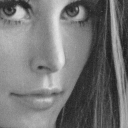

In [237]:
# if CHECKONSTEP:
Image.fromarray(mainblocks[10][0], 'L')


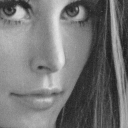

In [238]:
# if CHECKONSTEP:
Image.fromarray(combinedMainBlocks[10][0], 'L')


In [239]:
# if CHECKONSTEP:
combinedImg = combineBlocks(
    combinedMainBlocks.copy(), imgSize, mainblockSize)
combinedImg.shape, combinedImg
combinedImg = combinedImg.reshape(imgSize)
combinedImg.shape, combinedImg


((512, 512),
 array([[  0,   0,   0, ..., 169, 152, 129],
        [  0,   0,   0, ..., 170, 153, 128],
        [  0,   0,   0, ..., 171, 152, 128],
        ...,
        [ 41,  42,  48, ..., 106, 103,  96],
        [ 45,  46,  52, ..., 107, 105, 108],
        [ 45,  44,  55, ..., 107, 104, 111]], dtype=uint8))

In [240]:
# if CHECKONSTEP:
(combinedImg == img).all()


True

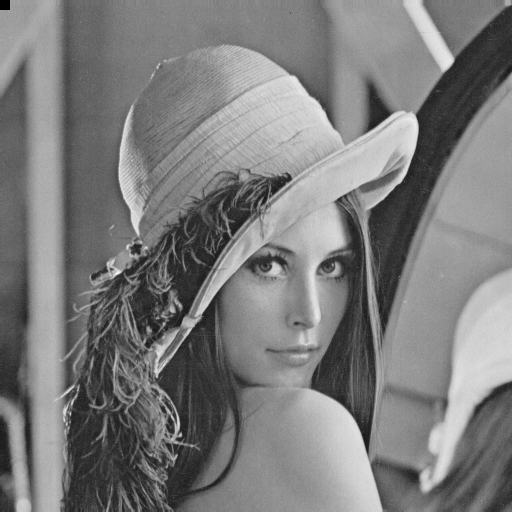

In [241]:
# if CHECKONSTEP:
Image.fromarray(combinedImg, 'L')


In [242]:
PSNR(img, combinedImg)


100

### Making 8x8 blocks of those 16x16 Step 9


In [243]:
blocks16x16.shape


(16, 1, 64, 16, 16)

In [244]:
blocks8x8Size = (8, 8)
# reshaping because we needed that shape
blocks8x8 = blocks16x16.copy().reshape(
    *blocks16x16.shape[:-2],
    int((blocks16x16Size[0]*blocks16x16Size[1]) /
        (blocks8x8Size[0]*blocks8x8Size[1])),
    blocks8x8Size[0], blocks8x8Size[1])

blocks8x8Size, blocks8x8.shape, blocks8x8.strides, blocks8x8


((8, 8),
 (16, 1, 64, 4, 8, 8),
 (16384, 16384, 256, 64, 8, 1),
 array([[[[[[  0,   0,   0, ...,   0,   0,   0],
            [  0,   0, 160, ..., 163, 160, 155],
            [  0,   0,   0, ...,   0,   0,   0],
            ...,
            [  0,   0, 161, ..., 162, 161, 152],
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0, 160, ..., 162, 160, 155]],
 
           [[  0,   0,   0, ...,   0,   0,   0],
            [  0,   0, 163, ..., 162, 163, 155],
            [  0,   0,   0, ...,   0,   0,   0],
            ...,
            [  0,   0, 159, ..., 154, 159, 152],
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0, 161, ..., 154, 155, 150]],
 
           [[  0,   0,   0, ...,   0,   0,   0],
            [  0,   0, 159, ..., 154, 158, 156],
            [  0,   0,   0, ...,   0,   0,   0],
            ...,
            [158, 159, 156, ..., 152, 156, 155],
            [159, 158, 157, ..., 154, 151, 151],
            [161, 156, 159, ..., 155, 158, 156

In [245]:
blocks8x8.shape


(16, 1, 64, 4, 8, 8)

In [246]:
blocks16x16.shape, blocks8x8.shape


((16, 1, 64, 16, 16), (16, 1, 64, 4, 8, 8))

In [247]:
for i in range(blocks16x16.shape[0]):
    for j in range(blocks16x16.shape[2]):
        blocks8x8[i][0][j] = getblocks(blocks16x16[i][0][j].copy(), blocks8x8Size,
                                       info=False, addChannel=False)

blocks8x8.shape, blocks8x8.strides, blocks8x8


((16, 1, 64, 4, 8, 8),
 (16384, 16384, 256, 64, 8, 1),
 array([[[[[[  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            ...,
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0]],
 
           [[  0,   0, 160, ..., 163, 160, 155],
            [  0,   0, 163, ..., 161, 163, 154],
            [  0,   0, 161, ..., 162, 161, 152],
            ...,
            [  0,   0, 155, ..., 154, 159, 154],
            [  0,   0, 159, ..., 154, 159, 152],
            [  0,   0, 161, ..., 154, 155, 150]],
 
           [[  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            [159, 156, 157, ..., 154, 152, 154],
            ...,
            [156, 159, 156, ..., 159, 156, 159],
            [156, 159, 158, ..., 159, 156, 159],
            [156, 157, 159, ..., 159, 156, 154]],
 
   

combining and checking


In [248]:
blocks8x8.shape, blocks16x16.shape, mainblocks.shape, img.shape


((16, 1, 64, 4, 8, 8), (16, 1, 64, 16, 16), (16, 1, 128, 128), (512, 512))

In [249]:
Image.fromarray(blocks8x8[10][0][0][0], 'L')


In [250]:
Image.fromarray(blocks8x8[10][0][0][1], 'L')


In [251]:
combined16x16 = blocks16x16.copy()


In [252]:
combined16x16.shape, blocks8x8.shape


((16, 1, 64, 16, 16), (16, 1, 64, 4, 8, 8))

In [253]:
for i in range(combined16x16.shape[0]):
    for j in range(combined16x16.shape[2]):
        combined16x16[i][0][j] = combineBlocks(blocks8x8[i][0][j].copy(), imageshape=(
            16, 16), blockshape=(8, 8), channel=False)
combined16x16.shape, combined16x16.strides, combined16x16


((16, 1, 64, 16, 16),
 (16384, 16384, 256, 16, 1),
 array([[[[[  0,   0,   0, ..., 163, 160, 155],
           [  0,   0,   0, ..., 161, 163, 154],
           [  0,   0,   0, ..., 162, 161, 152],
           ...,
           [156, 159, 156, ..., 153, 152, 162],
           [156, 159, 158, ..., 158, 158, 154],
           [156, 157, 159, ..., 158, 155, 169]],
 
          [[156, 159, 162, ..., 152, 153, 158],
           [156, 157, 160, ..., 152, 153, 159],
           [157, 156, 163, ..., 154, 154, 158],
           ...,
           [157, 154, 159, ..., 157, 156, 154],
           [153, 158, 155, ..., 152, 157, 156],
           [157, 154, 157, ..., 157, 159, 162]],
 
          [[155, 156, 153, ..., 175, 175, 168],
           [155, 156, 155, ..., 174, 172, 170],
           [155, 156, 155, ..., 174, 172, 171],
           ...,
           [156, 159, 156, ..., 168, 171, 168],
           [160, 163, 164, ..., 169, 170, 167],
           [164, 163, 160, ..., 167, 164, 170]],
 
          ...,
 
          [

In [254]:
Image.fromarray(combined16x16[10][0][0], 'L')


In [255]:
Image.fromarray(blocks16x16[10][0][0], 'L')


In [256]:
(combined16x16 == blocks16x16).all()


True

In [257]:
combinedMainBlocks = mainblocks.copy()


In [258]:
for i in range(combinedMainBlocks.shape[0]):
    combinedMainBlocks[i][0] = combineBlocks(
        combined16x16[i][0], mainblockSize, blockshape=(16, 16), channel=False)

combinedMainBlocks.shape, combinedMainBlocks


((16, 1, 128, 128),
 array([[[[  0,   0,   0, ..., 126, 135, 128],
          [  0,   0,   0, ..., 124, 134, 131],
          [  0,   0,   0, ..., 126, 132, 128],
          ...,
          [ 97,  99,  92, ..., 220, 208, 200],
          [ 89,  91,  93, ..., 219, 208, 190],
          [ 95,  92,  92, ..., 214, 207, 194]]],
 
 
        [[[133, 129, 135, ..., 130, 133, 136],
          [133, 131, 135, ..., 130, 134, 136],
          [135, 128, 134, ..., 130, 134, 137],
          ...,
          [189, 174, 144, ..., 186, 189, 195],
          [185, 178, 140, ..., 185, 187, 190],
          [189, 160, 163, ..., 179, 185, 180]]],
 
 
        [[[138, 142, 135, ..., 153, 152, 153],
          [138, 141, 132, ..., 153, 152, 153],
          [138, 141, 132, ..., 153, 153, 152],
          ...,
          [189, 185, 183, ..., 213, 219, 209],
          [197, 193, 185, ..., 217, 209, 203],
          [187, 198, 194, ..., 207, 195, 174]]],
 
 
        ...,
 
 
        [[[ 85, 105, 120, ...,  69,  68,  68],
       

In [259]:
combinedMainBlocks.shape


(16, 1, 128, 128)

In [260]:
(combinedMainBlocks == mainblocks).all()


True

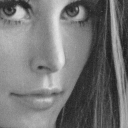

In [261]:
Image.fromarray(mainblocks[10][0], 'L')


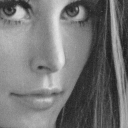

In [262]:
Image.fromarray(combinedMainBlocks[10][0], 'L')


In [263]:
combinedImg = combineBlocks(combinedMainBlocks.copy(), imgSize, mainblockSize)
combinedImg.shape, combinedImg
combinedImg = combinedImg.reshape(imgSize)
combinedImg.shape, combinedImg


((512, 512),
 array([[  0,   0,   0, ..., 169, 152, 129],
        [  0,   0,   0, ..., 170, 153, 128],
        [  0,   0,   0, ..., 171, 152, 128],
        ...,
        [ 41,  42,  48, ..., 106, 103,  96],
        [ 45,  46,  52, ..., 107, 105, 108],
        [ 45,  44,  55, ..., 107, 104, 111]], dtype=uint8))

In [264]:
(combinedImg == img).all()


True

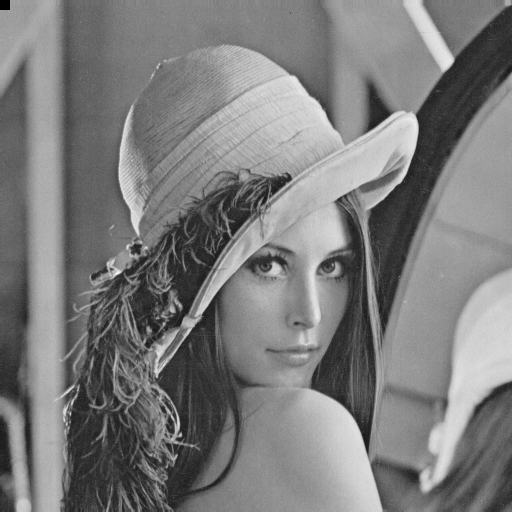

In [265]:
Image.fromarray(combinedImg, 'L')


In [266]:
PSNR(img, combinedImg)


100

Now put the recovery bit in the first and second LSB of blocks4x4


In [267]:
blocks8x8.shape


(16, 1, 64, 4, 8, 8)

In [268]:
recoveryBits.reshape(recoveryBits.shape[0], int(
    recoveryBits.shape[1]//2), 2).shape


(16, 12288, 2)

In [269]:
recoveryBits[0]


array([1, 1, 0, ..., 1, 1, 0], dtype=uint8)

In [270]:
recoveryBits.shape, blocks8x8.shape[2]*3*8*8*2


((16, 24576), 24576)

In [271]:
blocks8x8[:, 0, :, :3, :, :].shape, blocks8x8[:, 0, :, :3, :,
                                              :][0].shape, blocks8x8[:, 0, :, :3, :, :][0].flatten().shape


((16, 64, 3, 8, 8), (64, 3, 8, 8), (12288,))

updating the lsb


In [272]:
def set_bit(value, index, x):
    # """Set the index:th bit of v to 1 if x is truthy, else to 0, and return the new value."""
    # mask = 1 << index   # Compute mask, an integer with just bit 'index' set.
    # # Clear the bit indicated by the mask (if x is False)
    # value &= ~mask
    # if x:
    #     # If x was True, set the bit indicated by the mask.
    #     value |= mask
    # return value            # Return the result, we're done.
    def set_bit2(value, bit):
        return value | (1 << bit)

    def clear_bit(value, bit):
        return value & ~(1 << bit)

    if x:
        return set_bit2(value, index)
    else:
        return clear_bit(value, index)


def get_bit(value, index):
    if value & (1 << index):
        return True
    else:
        return False


In [273]:
set_bit(2, 3, 0), set_bit(2, 2, 1)
#(0, 6)


(2, 6)

In [274]:
bits = recoveryBits.reshape(
    recoveryBits.shape[0], int(recoveryBits.shape[1]//2), 2)
# for i in range(blocks8x8[:, 0].shape[0]):
#     for j in range(len(blocks8x8[i, 0, :, :3, :, :].flat)):
#         number = blocks8x8[i, 0, :, :3, :, :].flat[j]
#         blocks8x8[i, 0, :, :3, :, :].flat[j] = set_bit(
#             set_bit(number, 0, bits[i][j][0]), 1, bits[i][j][1])

# for mainblock, blockbits in zip(blocks8x8[:, 0, :, :3, :, :], recoveryBits.reshape(recoveryBits.shape[0], int(recoveryBits.shape[1]//2), 2)):
#     for number, bits in zip(mainblock.flat, blockbits):
#         # print(number, bits)
#         number = set_bit(set_bit(number, 0, bits[0]), 1, bits[1])

blocks8x8.shape, blocks8x8.strides, blocks8x8


((16, 1, 64, 4, 8, 8),
 (16384, 16384, 256, 64, 8, 1),
 array([[[[[[  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            ...,
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0]],
 
           [[  0,   0, 160, ..., 163, 160, 155],
            [  0,   0, 163, ..., 161, 163, 154],
            [  0,   0, 161, ..., 162, 161, 152],
            ...,
            [  0,   0, 155, ..., 154, 159, 154],
            [  0,   0, 159, ..., 154, 159, 152],
            [  0,   0, 161, ..., 154, 155, 150]],
 
           [[  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            [159, 156, 157, ..., 154, 152, 154],
            ...,
            [156, 159, 156, ..., 159, 156, 159],
            [156, 159, 158, ..., 159, 156, 159],
            [156, 157, 159, ..., 159, 156, 154]],
 
   

### get authenticaction bits


getting hash of four blocks with lsb 0


so we have the space of 128bit for hashing
we want to add the size of image + the blocknumber of eachblock
size will be multiple of 64
1byte of length, max length = 64*256=16384
1byte of width, max width = 64*256=16384
the remaing length for hash is now 112
for block number I'm excluding the 4 bits and 4bits will be reserved for the lookuptable
the make the total bits=104, that make 104/8=13bytes
we are using dynamic hasing algo (blake2b) with digest size 13bytes


In [275]:
HASH_SIZE = 16


In [276]:
def set_lsb_zero(num: np.ndarray):
    '''
    Clearing the first two LSB of ndarray
    '''
    return set_bit(set_bit(num, 0, 0), 1, 0)


'''
Data is one 16x16 block converted into four 8x8 blocks
'''


def hash_block(data: np.ndarray, key: str = None, digest_size=HASH_SIZE, extras=[]):
    if data.shape != (4, 8, 8):
        print(f"Warning! given size {data.shape} instead of (4, 8, 8)")
    local = data.copy().astype(np.int8)  # copying to avoid overighting lsb
    local[-1] = set_lsb_zero(local[-1])  # setting last 8x8 blocks lsb zero
    if key is None:
        h = hashlib.blake2b(digest_size=digest_size)
    else:
        h = hashlib.blake2b(key=key.encode())
    h.update(local.data)
    for extra in extras:
        h.update(extra.encode())
    return h


def put_bits(data: np.ndarray, bits: np.ndarray):
    '''
    puts data in last two lsb of data
    '''
    if data.shape != (8, 8):
        print(f"Warning! given size {data.shape} instead of (8, 8)")
    if bits.shape != (64, 2):
        print(f"Warning! given size {bits.shape} instead of (64, 2)")
    localData = data.copy().reshape(-1)
    localBits = bits.copy()
    '''
    setting last two lsb of data to bits
    '''
    localData = np.fromiter((set_bit(set_bit(d, 0, b[0]), 1, b[1]) for d, b in zip(
        localData, localBits)), dtype=data.dtype)

    return localData.reshape(8, 8)


def get_bits(data: np.ndarray):
    '''
    gets data from last two lsb of data
    '''
    if data.shape != (8, 8):
        print(f"Warning! given size {data.shape} instead of (8, 8)")
    localData = data.copy()
    bits = np.zeros((64, 2), np.uint8)
    bits[:, 0] = np.fromiter((get_bit(d, 0)
                             for d in localData.flat), dtype=np.uint8)
    bits[:, 1] = np.fromiter((get_bit(d, 1)
                             for d in localData.flat), dtype=np.uint8)
    return bits


In [277]:
blocks8x8[:, 0].shape, blocks8x8[:,
                                 0][0].shape, blocks8x8[:, 0][0].flatten().shape


((16, 64, 4, 8, 8), (64, 4, 8, 8), (16384,))

In [278]:
blocks8x8[:, 0].shape[:2]


(16, 64)

In [279]:
hashes = np.zeros((*blocks8x8[:, 0].shape[:2], HASH_SIZE*8), dtype=object)
hashes.shape, hashes


((16, 64, 128),
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0

In [280]:
def hexToDec(hexStr):
    return np.fromiter((int(x, 16) for x in hexStr), dtype=np.uint8)


def binToNp(binStr):
    return np.frombuffer(binStr, dtype=np.uint8)


has = hash_block(blocks8x8[0, 0, 1])

print(has, has.hexdigest(), len(has.digest()))
dec = binToNp(has.digest())
dec.shape, dec


<_blake2.blake2b object at 0x7f21d2d9d1b0> 11f3903f2b89118f1d0097215b88bb6d 16


((16,),
 array([ 17, 243, 144,  63,  43, 137,  17, 143,  29,   0, 151,  33,  91,
        136, 187, 109], dtype=uint8))

In [281]:
# binToNp(b'\x')


In [282]:
# hashes[0]='ashdadka'
# hashes


In [283]:
# type(hashlib.sha256("basd".encode()).hexdigest())


In [284]:
# hash_block(blocks8x8[0, 0, 0], digest_size=32)


In [285]:
# temp=hash_block(
#             blocks8x8[0, 0, 0])
# x=temp.digest()
# temp.hexdigest(), binToNp(temp.digest()), x, type(x), x.hex(), x[0], x[1].to_bytes(8, byteorder='big').hex()


so there are four block of 8x8
8x8 block has (2bits) _ 8 _ 8=128bit space


In [286]:
for i in range(blocks8x8[:, 0].shape[0]):
    for j in range(blocks8x8[:, 0].shape[1]):
        hashes[i][j] = np.unpackbits(binToNp(hash_block(
            blocks8x8[i, 0, j]).digest()))


hashes.shape, hashes[0][0], hashes


((16, 64, 128),
 array([0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1], dtype=object),
 array([[[0, 0, 1, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 0, 1],
         [0, 0, 1, ..., 0, 0, 1],
         ...,
         [0, 0, 0, ..., 1, 1, 1],
         [1, 1, 0, ..., 0, 1, 0],
         [1, 0, 1, ..., 1, 0, 1]],
 
        [[0, 1, 0, ..., 0, 1, 0],
         [0, 0, 1, ..., 1, 1, 1],
         [1, 1, 0, ..., 0, 1, 1],
         ...,
         [1, 1, 0, ..., 0, 1, 1],
         [1, 0, 0, ..., 1, 0, 0],
         [1, 0, 0, ..., 0, 0, 0]],
 
        [[1, 1, 0, ..., 1, 0, 0],
         [0, 1, 0, ..., 1, 0, 1],
         [1, 1, 0, ..., 0,

#### now we have to put this hash in the 4th 8x8 block of eaxh 16x16block :)


In [287]:
hashes.shape


(16, 64, 128)

In [288]:
bits.shape


(16, 12288, 2)

In [289]:
# reshaping it into 2bits in last for better placement
hashbits = hashes.reshape(
    hashes.shape[0], hashes.shape[1], hashes.shape[2]//2, 2)
hashbits.shape


(16, 64, 64, 2)

In [290]:
blocks8x8.shape


(16, 1, 64, 4, 8, 8)

In [291]:
blocks8x8[:, 0, :, 3, :, :].shape


(16, 64, 8, 8)

In [292]:
len(blocks8x8[:, 0, :, 3, :, :].flat)


65536

In [293]:
blocks8x8[i, 0, j, 3, :, :].shape


(8, 8)

In [294]:
blocks8x8[i, 0, j, 3, :, :].reshape(-1).shape


(64,)

In [295]:
hashbits[0][0].reshape(-1).shape


(128,)

In [296]:
prev8x8=blocks8x8.copy()

not the best approach
will do it like we did with recoverybits

In [297]:
# for i in range(blocks8x8[:, 0].shape[0]):
#     for j in range(blocks8x8[:, 0].shape[1]):
#         blocks8x8[i, 0, j, 3, :, :]=put_bits(blocks8x8[i, 0, j, 3, :, :], hashbits[i, j])

# blocks8x8.shape, blocks8x8.strides, blocks8x8


In [298]:
(prev8x8==blocks8x8).all()

True

### Now to combine the blocks back to Image


In [299]:
blocks8x8.shape, blocks16x16.shape, mainblocks.shape, img.shape


((16, 1, 64, 4, 8, 8), (16, 1, 64, 16, 16), (16, 1, 128, 128), (512, 512))

first merge the 8x8


In [300]:
Image.fromarray(blocks8x8[10][0][0][0], 'L')


In [301]:
Image.fromarray(blocks8x8[10][0][0][1], 'L')


In [302]:
combined16x16 = blocks16x16.copy()


In [303]:
combined16x16.shape, blocks8x8.shape


((16, 1, 64, 16, 16), (16, 1, 64, 4, 8, 8))

In [304]:
for i in range(combined16x16.shape[0]):
    for j in range(combined16x16.shape[2]):
        combined16x16[i][0][j] = combineBlocks(blocks8x8[i][0][j].copy(), imageshape=(
            16, 16), blockshape=(8, 8), channel=False)
combined16x16.shape, combined16x16.strides, combined16x16


((16, 1, 64, 16, 16),
 (16384, 16384, 256, 16, 1),
 array([[[[[  0,   0,   0, ..., 163, 160, 155],
           [  0,   0,   0, ..., 161, 163, 154],
           [  0,   0,   0, ..., 162, 161, 152],
           ...,
           [156, 159, 156, ..., 153, 152, 162],
           [156, 159, 158, ..., 158, 158, 154],
           [156, 157, 159, ..., 158, 155, 169]],
 
          [[156, 159, 162, ..., 152, 153, 158],
           [156, 157, 160, ..., 152, 153, 159],
           [157, 156, 163, ..., 154, 154, 158],
           ...,
           [157, 154, 159, ..., 157, 156, 154],
           [153, 158, 155, ..., 152, 157, 156],
           [157, 154, 157, ..., 157, 159, 162]],
 
          [[155, 156, 153, ..., 175, 175, 168],
           [155, 156, 155, ..., 174, 172, 170],
           [155, 156, 155, ..., 174, 172, 171],
           ...,
           [156, 159, 156, ..., 168, 171, 168],
           [160, 163, 164, ..., 169, 170, 167],
           [164, 163, 160, ..., 167, 164, 170]],
 
          ...,
 
          [

In [305]:
Image.fromarray(combined16x16[10][0][0], 'L')


In [306]:
Image.fromarray(blocks16x16[10][0][0], 'L')


In [307]:
(combined16x16 == blocks16x16).all()


True

merging 16x16 to 128x128


In [308]:
mainblocks.shape, blocks16x16.shape


((16, 1, 128, 128), (16, 1, 64, 16, 16))

In [309]:
combinedMainBlocks = mainblocks.copy()


In [310]:
for i in range(combinedMainBlocks.shape[0]):
    combinedMainBlocks[i][0] = combineBlocks(
        combined16x16[i][0], mainblockSize, blockshape=(16, 16), channel=False)

combinedMainBlocks.shape, combinedMainBlocks


((16, 1, 128, 128),
 array([[[[  0,   0,   0, ..., 126, 135, 128],
          [  0,   0,   0, ..., 124, 134, 131],
          [  0,   0,   0, ..., 126, 132, 128],
          ...,
          [ 97,  99,  92, ..., 220, 208, 200],
          [ 89,  91,  93, ..., 219, 208, 190],
          [ 95,  92,  92, ..., 214, 207, 194]]],
 
 
        [[[133, 129, 135, ..., 130, 133, 136],
          [133, 131, 135, ..., 130, 134, 136],
          [135, 128, 134, ..., 130, 134, 137],
          ...,
          [189, 174, 144, ..., 186, 189, 195],
          [185, 178, 140, ..., 185, 187, 190],
          [189, 160, 163, ..., 179, 185, 180]]],
 
 
        [[[138, 142, 135, ..., 153, 152, 153],
          [138, 141, 132, ..., 153, 152, 153],
          [138, 141, 132, ..., 153, 153, 152],
          ...,
          [189, 185, 183, ..., 213, 219, 209],
          [197, 193, 185, ..., 217, 209, 203],
          [187, 198, 194, ..., 207, 195, 174]]],
 
 
        ...,
 
 
        [[[ 85, 105, 120, ...,  69,  68,  68],
       

In [311]:
combinedMainBlocks.shape


(16, 1, 128, 128)

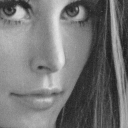

In [312]:
Image.fromarray(mainblocks[10][0], 'L')


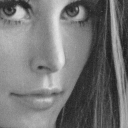

In [313]:
Image.fromarray(combinedMainBlocks[10][0], 'L')


In [314]:
(combinedMainBlocks == mainblocks).all()


True

In [315]:
combinedImg = combineBlocks(combinedMainBlocks.copy(), imgSize, mainblockSize)
combinedImg.shape, combinedImg
combinedImg = combinedImg.reshape(imgSize)
combinedImg.shape, combinedImg


((512, 512),
 array([[  0,   0,   0, ..., 169, 152, 129],
        [  0,   0,   0, ..., 170, 153, 128],
        [  0,   0,   0, ..., 171, 152, 128],
        ...,
        [ 41,  42,  48, ..., 106, 103,  96],
        [ 45,  46,  52, ..., 107, 105, 108],
        [ 45,  44,  55, ..., 107, 104, 111]], dtype=uint8))

In [316]:
(combinedImg == img).all()


True

combining to the image


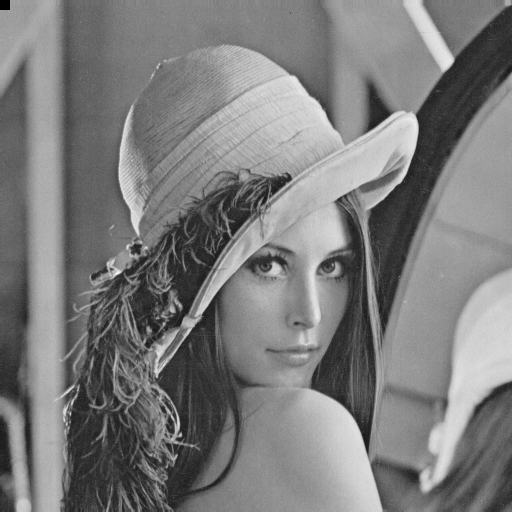

In [317]:
Image.fromarray(combinedImg, 'L')


In [318]:
PSNR(img, combinedImg)


100

In [319]:
done = time.time()
elapsed = done - start


In [320]:
print("This time includes all the unnessary outputs and checks")
elapsed


This time includes all the unnessary outputs and checks


17.240676403045654

In [321]:
# saving to file
Image.fromarray(combinedImg, 'L').save(f"{filename}_watermarked.png")


In [322]:
# # checking the saved file
# lena = Image.open(f"{filename}_watermarked.png").convert("L")
# img = np.array(lena)


In [323]:
(img == combinedImg).all()


True

# Auth

In [324]:
extractedHashes = np.zeros(hashbits.shape, dtype=hashbits.dtype)
extractedHashes.shape, extractedHashes


((16, 64, 64, 2),
 array([[[[0, 0],
          [0, 0],
          [0, 0],
          ...,
          [0, 0],
          [0, 0],
          [0, 0]],
 
         [[0, 0],
          [0, 0],
          [0, 0],
          ...,
          [0, 0],
          [0, 0],
          [0, 0]],
 
         [[0, 0],
          [0, 0],
          [0, 0],
          ...,
          [0, 0],
          [0, 0],
          [0, 0]],
 
         ...,
 
         [[0, 0],
          [0, 0],
          [0, 0],
          ...,
          [0, 0],
          [0, 0],
          [0, 0]],
 
         [[0, 0],
          [0, 0],
          [0, 0],
          ...,
          [0, 0],
          [0, 0],
          [0, 0]],
 
         [[0, 0],
          [0, 0],
          [0, 0],
          ...,
          [0, 0],
          [0, 0],
          [0, 0]]],
 
 
        [[[0, 0],
          [0, 0],
          [0, 0],
          ...,
          [0, 0],
          [0, 0],
          [0, 0]],
 
         [[0, 0],
          [0, 0],
          [0, 0],
          ...,
          [0

In [325]:
for i in range(blocks8x8[:, 0].shape[0]):
    for j in range(blocks8x8[:, 0].shape[1]):
        number = blocks8x8[i, 0, :, 3, :, :].flat[j]
        extractedHashes[i][j]=get_bits(blocks8x8[i, 0, j, 3, :, :])

blocks8x8.shape, blocks8x8.strides, blocks8x8


((16, 1, 64, 4, 8, 8),
 (16384, 16384, 256, 64, 8, 1),
 array([[[[[[  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            ...,
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0]],
 
           [[  0,   0, 160, ..., 163, 160, 155],
            [  0,   0, 163, ..., 161, 163, 154],
            [  0,   0, 161, ..., 162, 161, 152],
            ...,
            [  0,   0, 155, ..., 154, 159, 154],
            [  0,   0, 159, ..., 154, 159, 152],
            [  0,   0, 161, ..., 154, 155, 150]],
 
           [[  0,   0,   0, ...,   0,   0,   0],
            [  0,   0,   0, ...,   0,   0,   0],
            [159, 156, 157, ..., 154, 152, 154],
            ...,
            [156, 159, 156, ..., 159, 156, 159],
            [156, 159, 158, ..., 159, 156, 159],
            [156, 157, 159, ..., 159, 156, 154]],
 
   

In [326]:
extractedHashes


array([[[[0, 0],
         [0, 0],
         [1, 1],
         ...,
         [0, 1],
         [1, 1],
         [1, 0]],

        [[0, 0],
         [0, 1],
         [0, 0],
         ...,
         [1, 0],
         [1, 1],
         [0, 1]],

        [[0, 0],
         [1, 0],
         [1, 1],
         ...,
         [1, 1],
         [0, 0],
         [0, 1]],

        ...,

        [[0, 0],
         [0, 1],
         [0, 0],
         ...,
         [0, 0],
         [1, 1],
         [1, 1]],

        [[1, 1],
         [0, 0],
         [1, 0],
         ...,
         [1, 1],
         [1, 0],
         [1, 0]],

        [[1, 0],
         [1, 0],
         [0, 1],
         ...,
         [0, 1],
         [1, 1],
         [0, 1]]],


       [[[0, 1],
         [0, 1],
         [1, 0],
         ...,
         [0, 0],
         [1, 0],
         [1, 0]],

        [[0, 0],
         [1, 1],
         [1, 1],
         ...,
         [1, 1],
         [1, 1],
         [1, 1]],

        [[1, 1],
         [0, 1],
      

In [327]:
extractedHashes.reshape(-1).shape, hashbits.reshape(-1).shape


((131072,), (131072,))

In [328]:
extractedHashes.reshape(-1).shape, hashbits.reshape(-1).shape


((131072,), (131072,))

In [329]:
ret=(extractedHashes.reshape(-1) == hashbits.reshape(-1))
unique, counts = np.unique(ret, return_counts=True)
dic=dict(zip(unique, counts))
dic

{False: 73, True: 130999}

In [330]:
# if False in dic:
#   raise Exception("not all hashes are equal, embedding of auth bits are not correct")
# else:
#   print("all hashes are equal, embedding of auth bits are correct")

In [331]:
extractedHashes=extractedHashes.reshape(extractedHashes.shape[0], extractedHashes.shape[1], extractedHashes.shape[2]*2)
hashbits=hashbits.reshape(hashbits.shape[0], hashbits.shape[1], hashbits.shape[2]*2)
extractedHashes.shape, hashbits.shape


((16, 64, 128), (16, 64, 128))

In [332]:
tempred=np.zeros((extractedHashes.shape[0],extractedHashes.shape[1]), dtype=np.uint8)
tempred.shape

(16, 64)

In [333]:
for i in range(extractedHashes.shape[0]):
    for j in range(extractedHashes.shape[1]):
        tempred[i][j]=(extractedHashes[i][j]==hashbits[i][j]).all()

In [334]:
tempred

array([[0, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [335]:
unique, counts = np.unique(tempred, return_counts=True)
dict(zip(unique, counts))

{0: 1, 1: 1023}

In [336]:
orinaltempred=tempred.astype(bool)

In [337]:
tempred = np.where(tempred == 1, 255, tempred)

In [338]:
tempred.shape

(16, 64)

In [339]:
Image.fromarray(tempred, 'L')


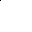

In [340]:
Image.fromarray(tempred.reshape(imgSize[0]//16,imgSize[1]//16), 'L')


In [341]:
temp=tempred.copy()

In [342]:
temp=temp.reshape(temp.shape[0], imgSize[0]//64,imgSize[1]//64)
temp.shape

(16, 8, 8)

In [343]:
temp=combineBlocks(temp,(imgSize[0]//16,imgSize[1]//16),(imgSize[0]//64,imgSize[1]//64),channel=False)
temp.shape

(32, 32)

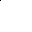

In [344]:
Image.fromarray(temp.reshape(imgSize[0]//16,imgSize[1]//16), 'L')


In [345]:
imgSize

(512, 512)

In [346]:
(imgSize[0]//16,imgSize[1]//16)

(32, 32)

# Recovery

In [347]:
extractedRecvBits=np.zeros(bits.shape, dtype=bits.dtype)
extractedRecvBits

array([[[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       ...,

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]]], dtype=uint8)

In [348]:
(blocks8x8==prev8x8).all()

True

In [349]:
blocks8x8[i, 0, :, :3, :, :].shape

(64, 3, 8, 8)

In [350]:
64*3*8*8

12288

In [351]:
for i in range(blocks8x8[:, 0].shape[0]):
  for j in range(len(blocks8x8[i, 0, :, :3, :, :].flat)):
    number= blocks8x8[i, 0, :, :3, :, :].flat[j]
    extractedRecvBits[i][j][0]=get_bit(number, 0)
    extractedRecvBits[i][j][1]=get_bit(number, 1)

In [352]:
extractedRecvBits

array([[[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 1],
        [1, 1],
        [1, 0]],

       [[1, 0],
        [1, 0],
        [1, 1],
        ...,
        [1, 0],
        [0, 1],
        [1, 0]],

       [[0, 1],
        [0, 1],
        [1, 1],
        ...,
        [1, 0],
        [0, 1],
        [1, 0]],

       ...,

       [[1, 0],
        [1, 0],
        [0, 0],
        ...,
        [0, 1],
        [1, 1],
        [1, 0]],

       [[1, 0],
        [0, 1],
        [1, 0],
        ...,
        [0, 1],
        [0, 1],
        [0, 1]],

       [[0, 1],
        [0, 1],
        [1, 1],
        ...,
        [1, 0],
        [0, 1],
        [1, 1]]], dtype=uint8)

In [353]:
bits.shape

(16, 12288, 2)

In [354]:
blocks8x8[:, 0].shape[0]

16

In [355]:
len(blocks8x8[i, 0, :, :3, :, :].flat)

12288

In [356]:
bits

array([[[1, 1],
        [0, 0],
        [1, 1],
        ...,
        [0, 1],
        [1, 1],
        [1, 0]],

       [[1, 0],
        [1, 0],
        [1, 1],
        ...,
        [1, 0],
        [0, 1],
        [1, 0]],

       [[0, 1],
        [0, 1],
        [1, 1],
        ...,
        [1, 0],
        [0, 1],
        [1, 1]],

       ...,

       [[0, 0],
        [0, 0],
        [0, 0],
        ...,
        [0, 1],
        [1, 1],
        [1, 0]],

       [[1, 0],
        [0, 1],
        [1, 0],
        ...,
        [0, 1],
        [0, 1],
        [0, 0]],

       [[0, 1],
        [0, 1],
        [1, 1],
        ...,
        [1, 0],
        [0, 1],
        [1, 1]]], dtype=uint8)

In [357]:
(extractedRecvBits==bits).all()

False

checking which 16s block is tempered
and within that A1 which 16x16 block are tempered
now replace 16x16 block with 4x4 average values

In [358]:
orinaltempred.shape, orinaltempred


((16, 64),
 array([[False,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]))

In [359]:
orinaltempred=~orinaltempred

In [360]:
tempred.shape

(16, 64)

In [361]:
mainblocks.shape, blocks16x16.shape

((16, 1, 128, 128), (16, 1, 64, 16, 16))

In [362]:
sum(orinaltempred.flat), orinaltempred.shape

(1, (16, 64))

now i know which 16x16 block of mainblocks is tempred. and after that I will replace the values from average

In [363]:
extractedRecvBits.shape

(16, 12288, 2)

In [364]:
formatedExtracted=extractedRecvBits.reshape(16,-1)
formatedExtracted.shape

(16, 24576)

In [365]:
lookup

array([[ 0,  7, 13, 10],
       [ 1,  6, 12, 11],
       [ 4,  2,  9, 15],
       [ 5,  3,  8, 14]], dtype=uint8)

In [366]:
A2Bits=formatedExtracted[lookup[0,1]]
A2Bits.shape

(24576,)

In [367]:
A1Bits=A2Bits[:A2Bits.shape[0]//3]
A1Bits.shape

(8192,)

In [368]:
decimal_bits=np.packbits(A1Bits)
decimal_bits.shape

(1024,)

In [369]:
(128*128) / (16*16)

64.0

In [370]:
cn=decimal_bits.reshape(-1,16)
cn.shape, cn

((64, 16),
 array([[161, 160, 162, ..., 164, 147, 118],
        [ 95,  96, 103, ..., 123, 126, 128],
        [159, 159, 160, ..., 162, 143, 116],
        ...,
        [ 75,  73,  82, ..., 111, 103, 178],
        [ 92,  92,  93, ..., 155, 137, 108],
        [ 77,  75,  82, ..., 114, 106, 200]], dtype=uint8))

In [371]:
orinaltempred.shape, orinaltempred

((16, 64),
 array([[ True, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]))

In [372]:
blocks16x16.shape

(16, 1, 64, 16, 16)

In [373]:
blocks16x16[0,0,0].shape #this is tempred 16x16

(16, 16)

In [374]:
blocks164x164=getblocks(blocks16x16[0,0,0].copy(), avgblocksSize,
                                 info=False, addChannel=False)

In [375]:
blocks164x164.shape

(16, 4, 4)

In [376]:
cn[0].shape,cn[0]

((16,),
 array([161, 160, 162, 158, 158, 155, 154, 155, 156, 162, 167, 172, 171,
        164, 147, 118], dtype=uint8))

In [377]:
blocks164x164[0,:,:]

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint8)

In [378]:
# replace values
for i in range (16):
  blocks164x164[i,:,:]=cn[0,i]

In [379]:
blocks164x164

array([[[161, 161, 161, 161],
        [161, 161, 161, 161],
        [161, 161, 161, 161],
        [161, 161, 161, 161]],

       [[160, 160, 160, 160],
        [160, 160, 160, 160],
        [160, 160, 160, 160],
        [160, 160, 160, 160]],

       [[162, 162, 162, 162],
        [162, 162, 162, 162],
        [162, 162, 162, 162],
        [162, 162, 162, 162]],

       [[158, 158, 158, 158],
        [158, 158, 158, 158],
        [158, 158, 158, 158],
        [158, 158, 158, 158]],

       [[158, 158, 158, 158],
        [158, 158, 158, 158],
        [158, 158, 158, 158],
        [158, 158, 158, 158]],

       [[155, 155, 155, 155],
        [155, 155, 155, 155],
        [155, 155, 155, 155],
        [155, 155, 155, 155]],

       [[154, 154, 154, 154],
        [154, 154, 154, 154],
        [154, 154, 154, 154],
        [154, 154, 154, 154]],

       [[155, 155, 155, 155],
        [155, 155, 155, 155],
        [155, 155, 155, 155],
        [155, 155, 155, 155]],

       [[156, 156, 156, 

In [380]:
# combine back
combined164= combineBlocks(blocks164x164.copy(), (16,16),(4,4),channel=False)
combined164.shape, combined164

((16, 16),
 array([[161, 161, 161, 161, 160, 160, 160, 160, 162, 162, 162, 162, 158,
         158, 158, 158],
        [161, 161, 161, 161, 160, 160, 160, 160, 162, 162, 162, 162, 158,
         158, 158, 158],
        [161, 161, 161, 161, 160, 160, 160, 160, 162, 162, 162, 162, 158,
         158, 158, 158],
        [161, 161, 161, 161, 160, 160, 160, 160, 162, 162, 162, 162, 158,
         158, 158, 158],
        [158, 158, 158, 158, 155, 155, 155, 155, 154, 154, 154, 154, 155,
         155, 155, 155],
        [158, 158, 158, 158, 155, 155, 155, 155, 154, 154, 154, 154, 155,
         155, 155, 155],
        [158, 158, 158, 158, 155, 155, 155, 155, 154, 154, 154, 154, 155,
         155, 155, 155],
        [158, 158, 158, 158, 155, 155, 155, 155, 154, 154, 154, 154, 155,
         155, 155, 155],
        [156, 156, 156, 156, 162, 162, 162, 162, 167, 167, 167, 167, 172,
         172, 172, 172],
        [156, 156, 156, 156, 162, 162, 162, 162, 167, 167, 167, 167, 172,
         172, 172, 172],

In [381]:
blocks16x16[0,0,0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 160, 162, 152,
        163, 160, 155],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 163, 162, 152,
        161, 163, 154],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 161, 161, 153,
        162, 161, 152],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 160, 161, 153,
        162, 160, 155],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 163, 163, 153,
        162, 163, 155],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 155, 159, 153,
        154, 159, 154],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 159, 161, 153,
        154, 159, 152],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 161, 161, 153,
        154, 155, 150],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 159, 160, 158,
        154, 158, 156],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 155, 158, 157,
        157, 159, 154],
       [159, 156, 157, 163, 15

In [382]:
blocks16x16[0,0,0]=combined164

In [383]:
Image.fromarray(blocks16x16[0][0][0], 'L')

In [384]:
for i in range(combinedMainBlocks.shape[0]):
    combinedMainBlocks[i][0] = combineBlocks(
        blocks16x16[i][0].copy(), mainblockSize, blockshape=(16, 16), channel=False)


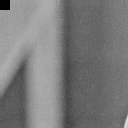

In [385]:
# if CHECKONSTEP:
Image.fromarray(mainblocks[0][0], 'L')


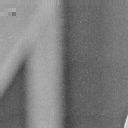

In [386]:
Image.fromarray(combinedMainBlocks[0][0], 'L')

In [387]:
# if CHECKONSTEP:
combinedImg = combineBlocks(
    combinedMainBlocks.copy(), imgSize, mainblockSize)
combinedImg.shape, combinedImg
combinedImg = combinedImg.reshape(imgSize)
combinedImg.shape, combinedImg


((512, 512),
 array([[161, 161, 161, ..., 169, 152, 129],
        [161, 161, 161, ..., 170, 153, 128],
        [161, 161, 161, ..., 171, 152, 128],
        ...,
        [ 41,  42,  48, ..., 106, 103,  96],
        [ 45,  46,  52, ..., 107, 105, 108],
        [ 45,  44,  55, ..., 107, 104, 111]], dtype=uint8))

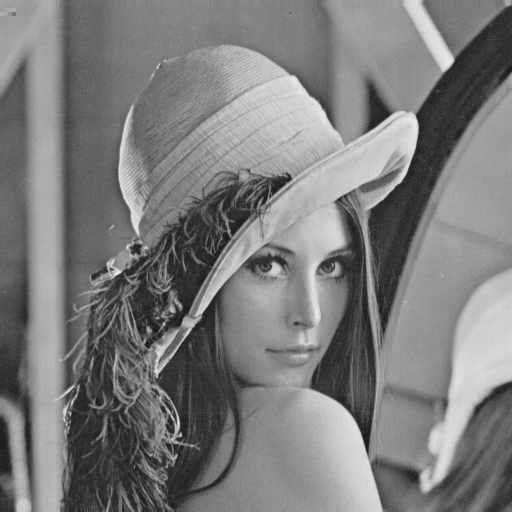

In [388]:
# if CHECKONSTEP:
Image.fromarray(combinedImg, 'L')


In [390]:
Image.fromarray(combinedImg, 'L').save(f"{filename}_combined.png")

In [389]:
raise Exception("sasd")

Exception: sasd

In [ ]:
64*3*8*8

12288

In [ ]:
128/4

32.0

16 main blocks of size 128x128
64 sub 16x16 blocks
now I have to select the partener block of tempred image and for that block I have to extract all the 2lsb of 38x8 blocks. 
After that permute back
then ab un recoery bits of 4x4 me convert karna, and ye wala step har 16x16 k leye karna for the partenet main block.

ab jab mery paas 4x4 ki avg aa jain gi to me tempered 16x16 block ko unki avg values sy replace kar doon ga



In [ ]:
lookup

array([[ 0,  7, 13, 10],
       [ 1,  6, 12, 11],
       [ 4,  2,  9, 15],
       [ 5,  3,  8, 14]], dtype=uint8)

In [ ]:
# suppose the main block 0 k ander 0th 16x16 block tempred hae
orinaltempred[0][0]=True
orinaltempred.shape, orinaltempred[0][0]

((16, 64), True)

har 16x16 k leye 8*8*2 hae and kiun k haam 3 blocks use kar rhy to 8*8*2*3 = 384 


In [ ]:
formatedExtracted=extractedRecvBits.reshape(extractedRecvBits.shape[0],orinaltempred.shape[1],  2*(extractedRecvBits.shape[1]//orinaltempred.shape[1]))
formatedExtracted.shape

(16, 64, 384)

to ab A1 ka 0th 16x16 tempered that
to ab hamary paas A2 ki sari bits hain. 64*384 = 24576

ab kiun k meny suppose kia k 0th block kharab hae to me 0th main block k 16x16 ki sari bits nikal loon ga

In [ ]:
firstmainblockbits=formatedExtracted[0].reshape(-1)
firstmainblockbits, firstmainblockbits.shape

(array([0, 0, 0, ..., 1, 0, 0], dtype=uint8), (24576,))

ab in bits ko meny 4x4 ki shape deni

In [ ]:
24576/2

12288.0

In [ ]:
24576/(16)

1536.0

ab jo hae wo permutation karni hamny wapas

and permute karny k baad dobara 16x16 k leye nikalny

In [ ]:
# permutation here

In [ ]:
firstmainblockbits.shape

(24576,)

In [ ]:
# 16 x 16 me convert karo
recv16x16=firstmainblockbits.reshape(-1,16,16)
recv16x16.shape

(96, 16, 16)

In [ ]:
# ab har 16x16 ko 4x4 me kar
recv4x4=recv16x16.reshape(-1,16,16,4,4)
recv4x4.shape

(6, 16, 16, 4, 4)

In [ ]:
blocks8x8.shape

(16, 1, 64, 4, 8, 8)

In [ ]:
# reshaped=firstmainblockbits.reshape(firstmainblockbits.shape[0]//16, 4, 4)
# reshaped.shape

In [ ]:
128/4

32.0

In [ ]:
32*32

1024

In [ ]:
Image.fromarray(reshaped.reshape(12288,12288))

NameError: name 'reshaped' is not defined